# **Block -3 : ML Modeling ==> Linear Regression, Decision Tree and XGBoost**

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib
import matplotlib.pyplot as plt
import shap
import xgboost as xgb

In [2]:
ml_data = pd.read_csv("ml_data.csv")

In [3]:
ml_data.head()

,PatientID,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,PremiumPrice,BMI,#MajorSurgeries
0,1,45,0,0,0,0,0,0,25000,23.73,0
1,2,60,1,0,0,0,0,0,29000,22.53,0
2,3,36,1,1,0,0,0,0,23000,23.63,1
3,4,52,1,1,0,1,0,0,28000,27.77,2
4,5,38,0,0,0,1,0,0,23000,31.93,1


In [4]:
X = ml_data.drop(columns=["PatientID","PremiumPrice"])
y = ml_data["PremiumPrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
## Scaling numerical columns for Linear Regression
num_cols = ["Age","BMI"]
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

## **Linear Regression**

In [6]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))

Linear Regression RMSE: 3530.8967391854853
Linear Regression R²: 0.7076356558969149


## **Descision Tree**

In [7]:
dt = DecisionTreeRegressor(random_state=42)
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None,'sqrt', 'log2']
}
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='r2')
dt_grid.fit(X_train, y_train)  # No scaling required for trees
dt_best = dt_grid.best_estimator_
y_pred_dt = dt_best.predict(X_test)

print("Best DT params:", dt_grid.best_params_)
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print("Decision Tree R²:", r2_score(y_test, y_pred_dt))

Best DT params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 20}
Decision Tree RMSE: 2686.2735009777775
Decision Tree R²: 0.8307787773866588


## **XGBoost**

In [8]:
# XGBoost regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter tuning
xgb_params = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
xgb_grid = RandomizedSearchCV(xgb, xgb_params, n_iter=30, cv=5, scoring='neg_root_mean_squared_error', random_state=42)
xgb_grid.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'n_estimators': [200, 300, ...], ...}"
,n_iter,30
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [9]:
xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)

print("Best XGBoost params:", xgb_grid.best_params_)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))

Best XGBoost params: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
XGBoost RMSE: 2538.146370877771
XGBoost R²: 0.8489267230033875


## **Results of all models**

In [10]:
models = {'LinearRegression': lr,
          'DecisionTree': dt_best,
          'XGBoost': xgb_best}

results = []

for name, model in models.items():
    # Getting confidence intervals for Linear regression
    if name == 'LinearRegression':
        y_pred = model.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Getting confidence intervals for LR
        X_test_sm = sm.add_constant(X_test_scaled)
        predictions = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit().get_prediction(X_test_sm)
        pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI
    else:
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    
    results.append([name, rmse, mae, r2])

results_df = pd.DataFrame(results, columns=['Model','RMSE','MAE','R²'])
prediction_summary = pred_summary[['mean', 'mean_ci_lower','mean_ci_upper','obs_ci_lower','obs_ci_upper']]

In [11]:
print(results_df)

              Model         RMSE          MAE        R²
0  LinearRegression  3530.896739  2629.890707  0.707636
1      DecisionTree  2686.273501  1753.345071  0.830779
2           XGBoost  2538.146371  1773.768921  0.848927


### **Results**
#### Based on the RMSE, MAE and R-squared values for all three models, XGBoost is the best performing model with R-squared of 0.8489, with RMSE 2538.146 and MAE 1773.768 followed by Decision Tree based model having R-squared of 0.8307, with RMSE 2686.2735 and MAE 1753.345. Linear Regression model performed the worst among the three models with R-squared 0.7076, RMSE 3530.8967 and MAE 2629.8907. 

In [12]:
print(prediction_summary)

             mean  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
613  28454.148891   27413.444744   29494.853037  20803.208287  36105.089494
451  26121.810828   24968.919433   27274.702222  18454.804531  33788.817125
731  31524.092759   30675.069839   32373.115679  23896.860829  39151.324689
436  20204.159680   19221.795882   21186.523478  12560.936170  27847.383190
275  25740.605478   24846.072203   26635.138754  18108.173574  33373.037383
..            ...            ...            ...           ...           ...
209  29461.039644   28169.267376   30752.811911  21771.923792  37150.155495
506  26463.713171   25826.505940   27100.920402  18857.146268  34070.280074
49   17305.954308   16685.766292   17926.142324   9700.794206  24911.114409
717  24965.057310   24227.970688   25702.143932  17349.473046  32580.641574
964  18319.290742   17702.543185   18936.038299  10714.410431  25924.171053

[198 rows x 5 columns]


### Saving models to pkl files

In [13]:
joblib.dump(lr, "./models/LinearRegression_model.pkl")
joblib.dump(dt_best, "./models/DecisionTree_tuned_model.pkl")
joblib.dump(xgb_best, "./models/XGBoost_tuned_model.pkl")

['./models/XGBoost_tuned_model.pkl']

## **Post Prediction Analysis**

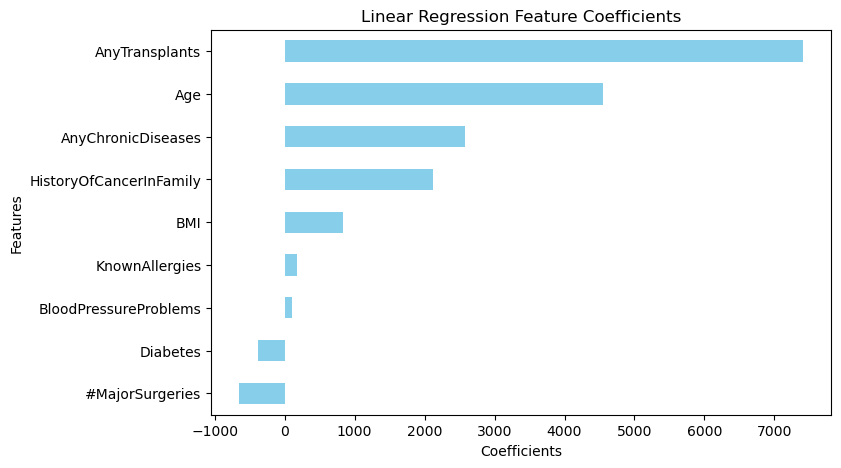

In [14]:
# Linear Regression Coefficients
coef_df = pd.Series(lr.coef_,index=X_train.columns).sort_values(ascending=True)
coef_df.plot(kind='barh', color="skyblue",figsize=(8,5))
plt.title("Linear Regression Feature Coefficients")
plt.xlabel("Coefficients")
plt.ylabel("Features")
plt.show()

### From the coefficients plot for all the features, it can be seen that the features AnyTransplants, Age, AnyChronicDiseases, HistoryOfCancerInFamily and BMI have high coefficient values indicating that these features have a positive impact on the target variable, i.e PremiumPrices.

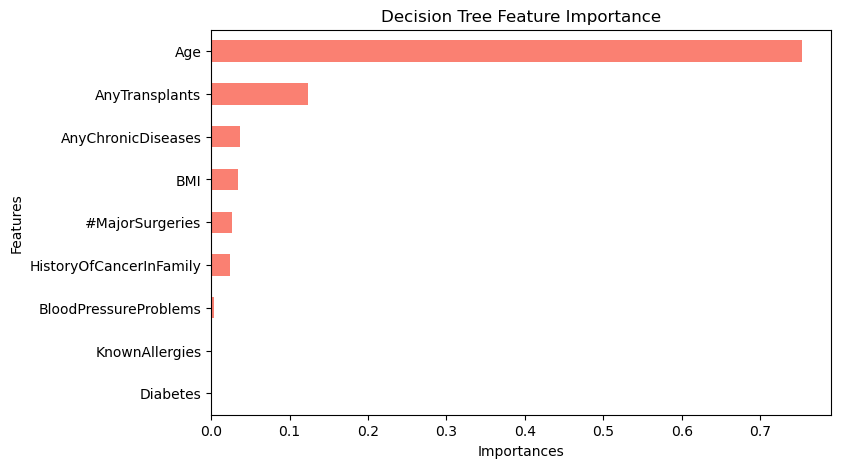

In [15]:
# Decision Tree / XGBoost feature importance
feat_imp_df = pd.Series(dt_best.feature_importances_,index=X_train.columns).sort_values(ascending=True)
feat_imp_df.plot(kind='barh',figsize=(8,5), color="salmon")
plt.title("Decision Tree Feature Importance")
plt.xlabel("Importances")
plt.ylabel("Features")
plt.show()

### From the feature importances plot for the Decision Tree algorithm, the variables Age, AnyTransplants have high importances values while AnyChronicDiseases, BMI, #MajorSurgeries and HistoryOfCancerInFamily have very small importances values indicating that these features did not contribute much to the PremiumPrice prediction.

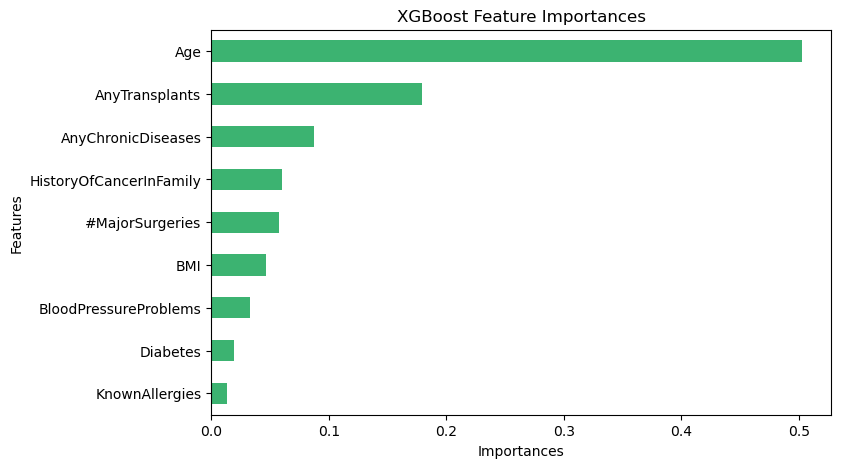

In [16]:
import pandas as pd

importances = pd.Series(xgb_best.feature_importances_, index=X_train.columns).sort_values(ascending=True)
importances.plot(kind="barh", figsize=(8,5),color="mediumseagreen")
plt.title("XGBoost Feature Importances")
plt.xlabel("Importances")
plt.ylabel("Features")
plt.show()

### From the feature importances plot for the XGBoost algorithm, the variables Age, AnyTransplants have high importances values while AnyChronicDiseases, HistoryOfCancerInFamily, #MajorSurgeries, BMI, BloodPressureProblems, Diabetes, and KnownAllergies have very small importances values indicating that these features did not contribute much to the PremiumPrice prediction.

## **Residual Distribution plots**

In [18]:
import seaborn as sns

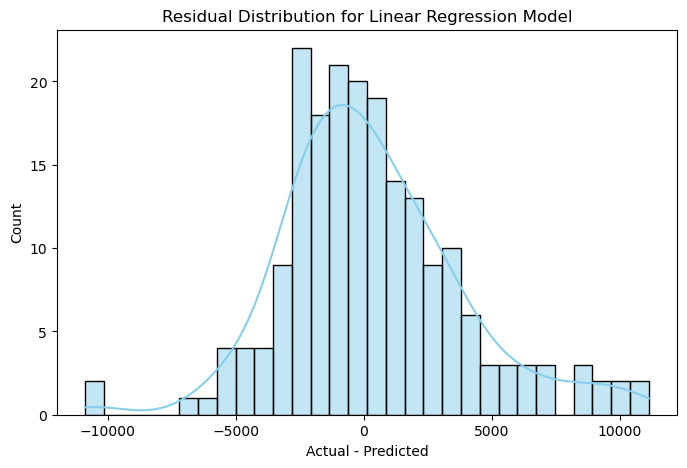

In [19]:
y_pred = lr.predict(X_test_scaled)
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.title(f"Residual Distribution for Linear Regression Model")
plt.xlabel("Actual - Predicted")
plt.show()

### For the Linear Regression model, the residuals are mostly in the range of -5000 to +5000 and follow an approximately normal distribution with a slight right skew. This suggests that in most cases, the model slightly underestimates the actual premium values.

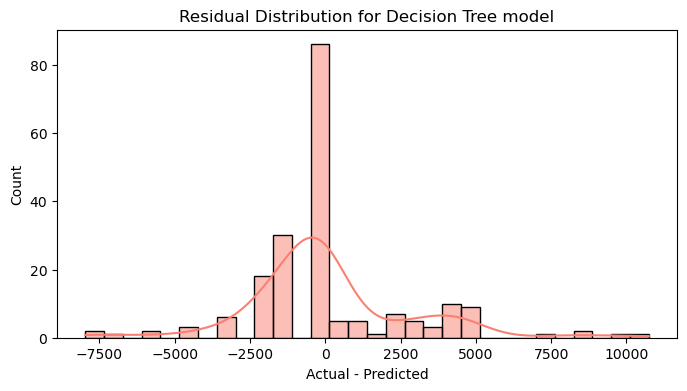

In [20]:
y_pred = dt_best.predict(X_test)
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True, bins=30, color='salmon')
plt.title(f"Residual Distribution for Decision Tree model")
plt.xlabel("Actual - Predicted")
plt.show()

### For the Decision Tree model, residuals are mostly within the range of -2500 to +2500 and are slightly skewed towards negative values, with the highest frequency around -1500. This indicates that the model tends to slightly overestimate premiums in many cases.

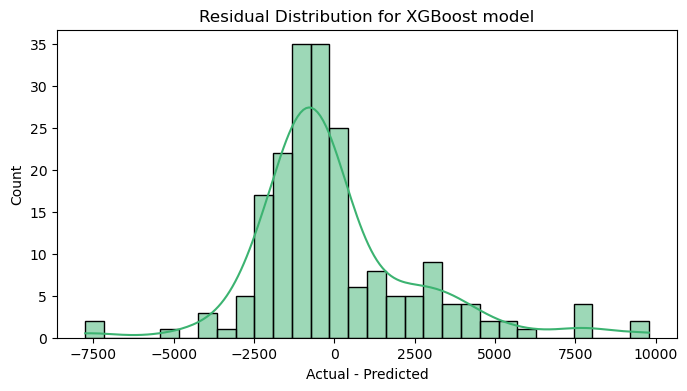

In [21]:
y_pred = xgb_best.predict(X_test)
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True, bins=30, color='mediumseagreen')
plt.title(f"Residual Distribution for XGBoost model")
plt.xlabel("Actual - Predicted")
plt.show()

### For the XGBoost algorithm, residuals are mostly within the range of -2500 to 0 with a slight right skew. For the XGBoost model, residuals are mostly within the range of -2500 to 0 and exhibit a slight right skew. This indicates that the model tends to slightly overestimate premiums for many cases, but extreme underestimations are less common.

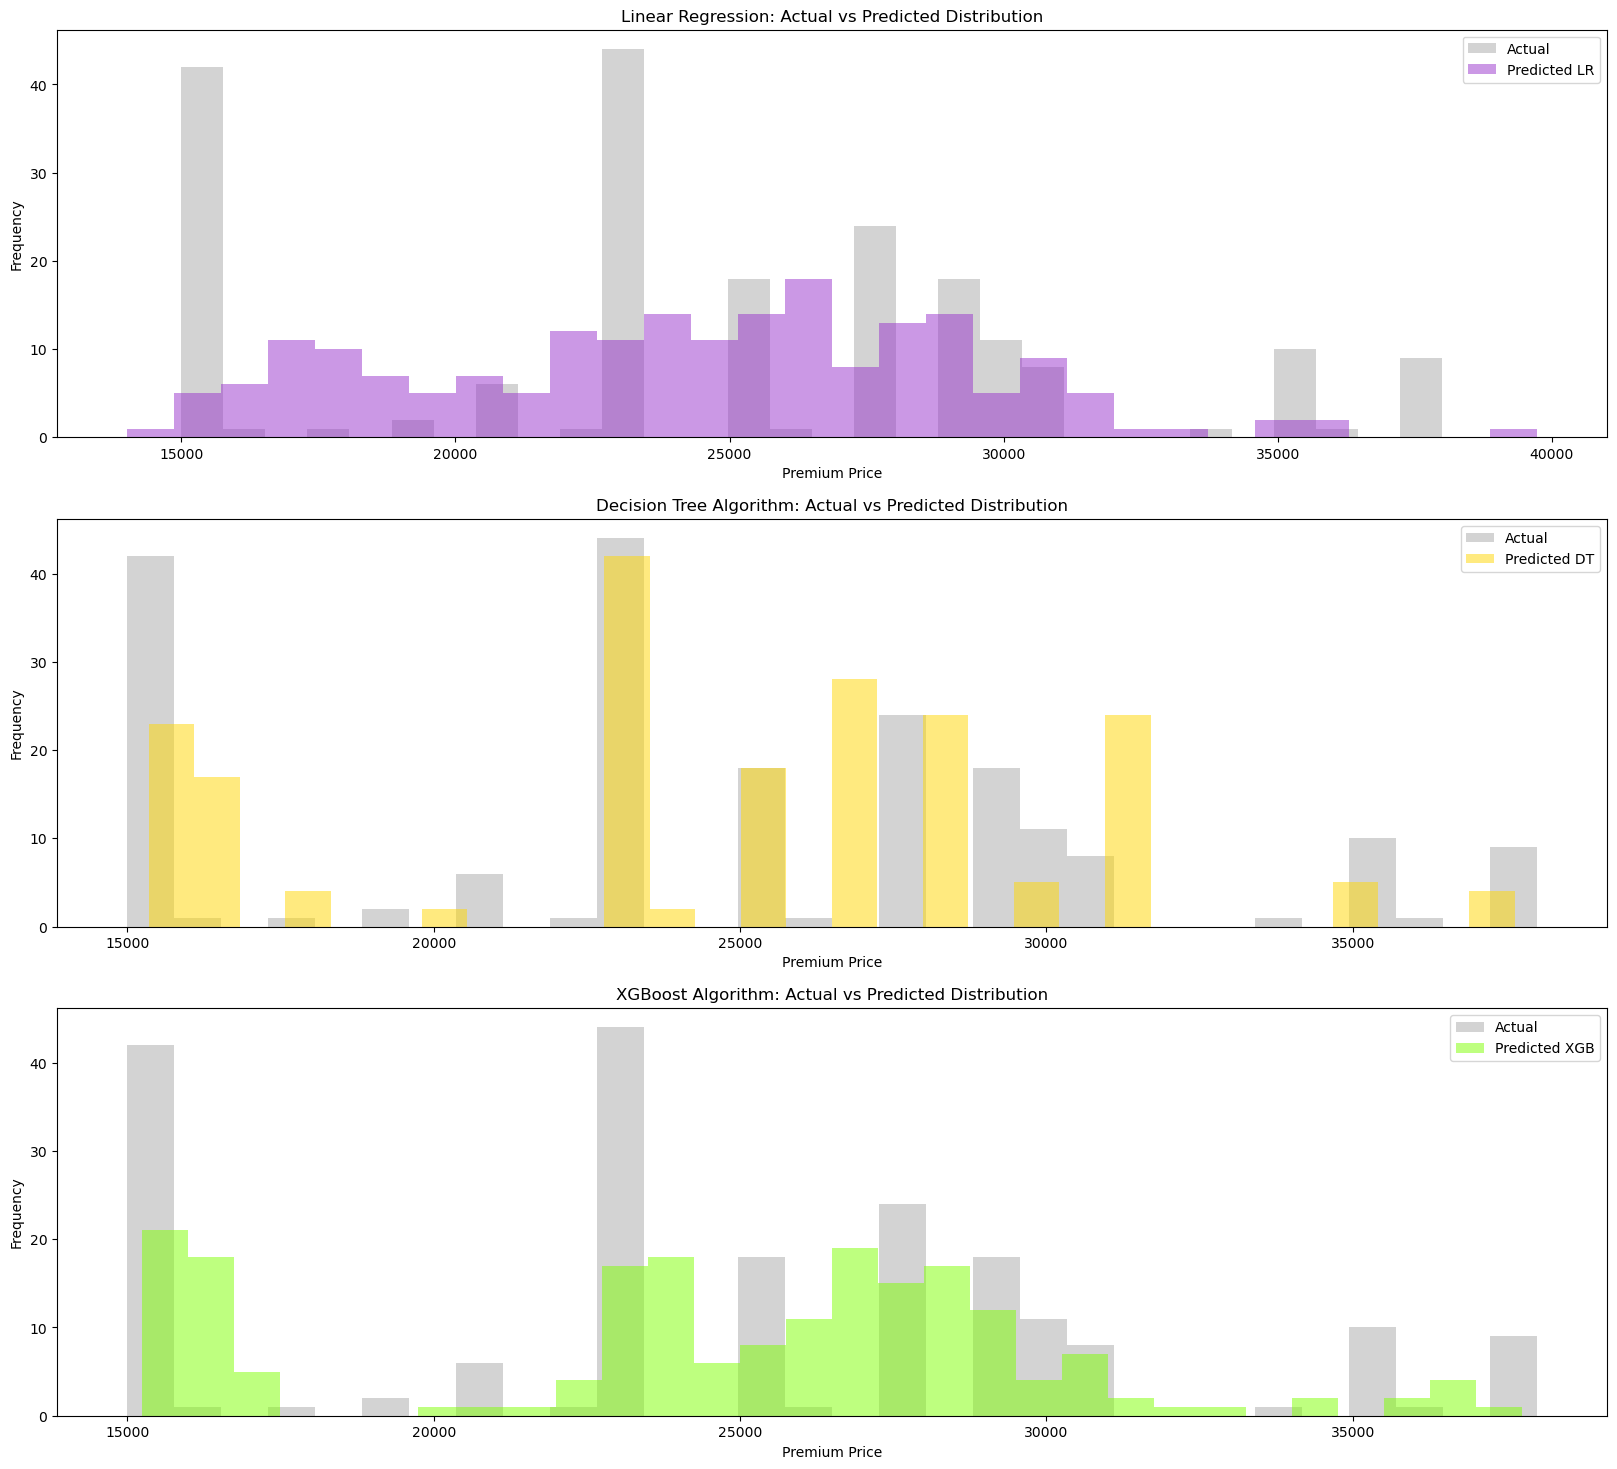

In [22]:
figure, ax = plt.subplots(nrows=3, ncols=1, figsize= (20,18))
# Error / Prediction overlay
ax[0].hist(y_test, bins=30, alpha=0.5, label='Actual',color="darkgrey")
ax[0].hist(lr.predict(X_test_scaled), bins=30, alpha=0.5, label='Predicted LR',color="darkorchid")
ax[0].legend()
ax[0].set_title("Linear Regression: Actual vs Predicted Distribution")
ax[0].set_xlabel("Premium Price")
ax[0].set_ylabel("Frequency")

ax[1].hist(y_test, bins=30, alpha=0.5, label='Actual',color="darkgrey")
ax[1].hist(dt_best.predict(X_test), bins=30, alpha=0.5, label='Predicted DT',color="gold")
ax[1].legend()
ax[1].set_title("Decision Tree Algorithm: Actual vs Predicted Distribution")
ax[1].set_xlabel("Premium Price")
ax[1].set_ylabel("Frequency")

ax[2].hist(y_test, bins=30, alpha=0.5, label='Actual',color="darkgrey")
ax[2].hist(xgb_best.predict(X_test), bins=30, alpha=0.5, label='Predicted XGB',color="chartreuse")
ax[2].legend()
ax[2].set_title("XGBoost Algorithm: Actual vs Predicted Distribution")
ax[2].set_xlabel("Premium Price")
ax[2].set_ylabel("Frequency")

plt.show()

## **Interpretation of actual vs predicted value distributions**
### ***Linear Regression:*** 
* The distribution overlay indicates that most predicted premium values lie between 10,000 and 37,000, while actual premium values extend beyond 35,000. However, the model produces very few predictions above 32,000, suggesting limited ability to capture extreme high-premium cases. This implies that the Linear Regression model performs better for low- to medium-risk individuals but underestimates premiums for high-risk cases.
* Within the 10,000–32,000 range, the predicted values appear more uniformly distributed, whereas the actual values show distinct peaks and troughs, indicating clustered pricing in the real data. This smoothing effect suggests that the Linear Regression model is oversimplifying the underlying data structure and is unable to capture non-linear relationships and interactions present in the dataset.
#### **Conclusion**: Linear Regression provides stable baseline predictions but fails to model the heavy-tailed and clustered nature of premium prices, limiting its effectiveness for high-risk policyholders.
### ***Decision Tree alg:*** 
* The overlap between actual and predicted premium values is strong for low to medium premium ranges, indicating that the Decision Tree model captures pricing patterns well for the majority of policyholders.
* However, in the range of approximately 27,000 to 35,000, the predictions show noticeable discrepancies, including a clear gap between ~28,000 and ~32,000, where few or no predictions are produced.
* Beyond 35,000, the model again aligns well with actual values, suggesting that the tree has learned specific high-premium segments effectively.
* Compared to Linear Regression, the Decision Tree’s predictions are more discrete and irregular, reflecting its ability to model non-linear relationships and interaction effects. This behavior indicates a better fit to the dataset’s complexity, albeit at the cost of smoothness.
#### **Conclusion**: The Decision Tree captures non-linear premium patterns more effectively than Linear Regression but produces discontinuous predictions due to its piecewise-constant structure.
### ***XGBoost alg:*** 
* The XGBoost model shows good overlap between actual and predicted values across the low to mid-range premium values (approximately 15,000–30,000), indicating strong predictive performance for the majority of policyholders.
* Compared to Linear Regression, the predicted values are less uniformly spread and instead show clear concentration around regions where actual values have high density, suggesting that XGBoost is better at learning the underlying data distribution rather than producing averaged predictions.
* In the 23,000–32,000 range, predictions appear more evenly distributed, covering most of the observed actual value peaks. This indicates improved handling of non-linear relationships and interactions among predictors compared to the simpler models.
* However, beyond approximately 32,000, the frequency of predicted values drops sharply. Although actual premium values exhibit peaks around 35,000 and higher, these peaks are not fully captured by the model. This behavior suggests that XGBoost tends to under-predict extreme high premium values, likely due to:
  1. Fewer high-value observations in the training data.
  2. Regularization and tree-splitting constraints that favor conservative predictions.
  3. The model prioritizing accuracy in densely populated regions of the feature space
* Overall, XGBoost provides the best balance between bias and variance among the three models, achieving strong performance across most of the distribution while sacrificing some accuracy in predicting rare, high-premium cases.
#### **Conclusion**: While XGBoost demonstrates superior overall predictive performance and better captures non-linear patterns compared to Linear Regression and Decision Tree models, it remains conservative when predicting extreme premium values, highlighting an area for potential improvement through re-weighting, custom loss functions, or stratified modeling approaches.

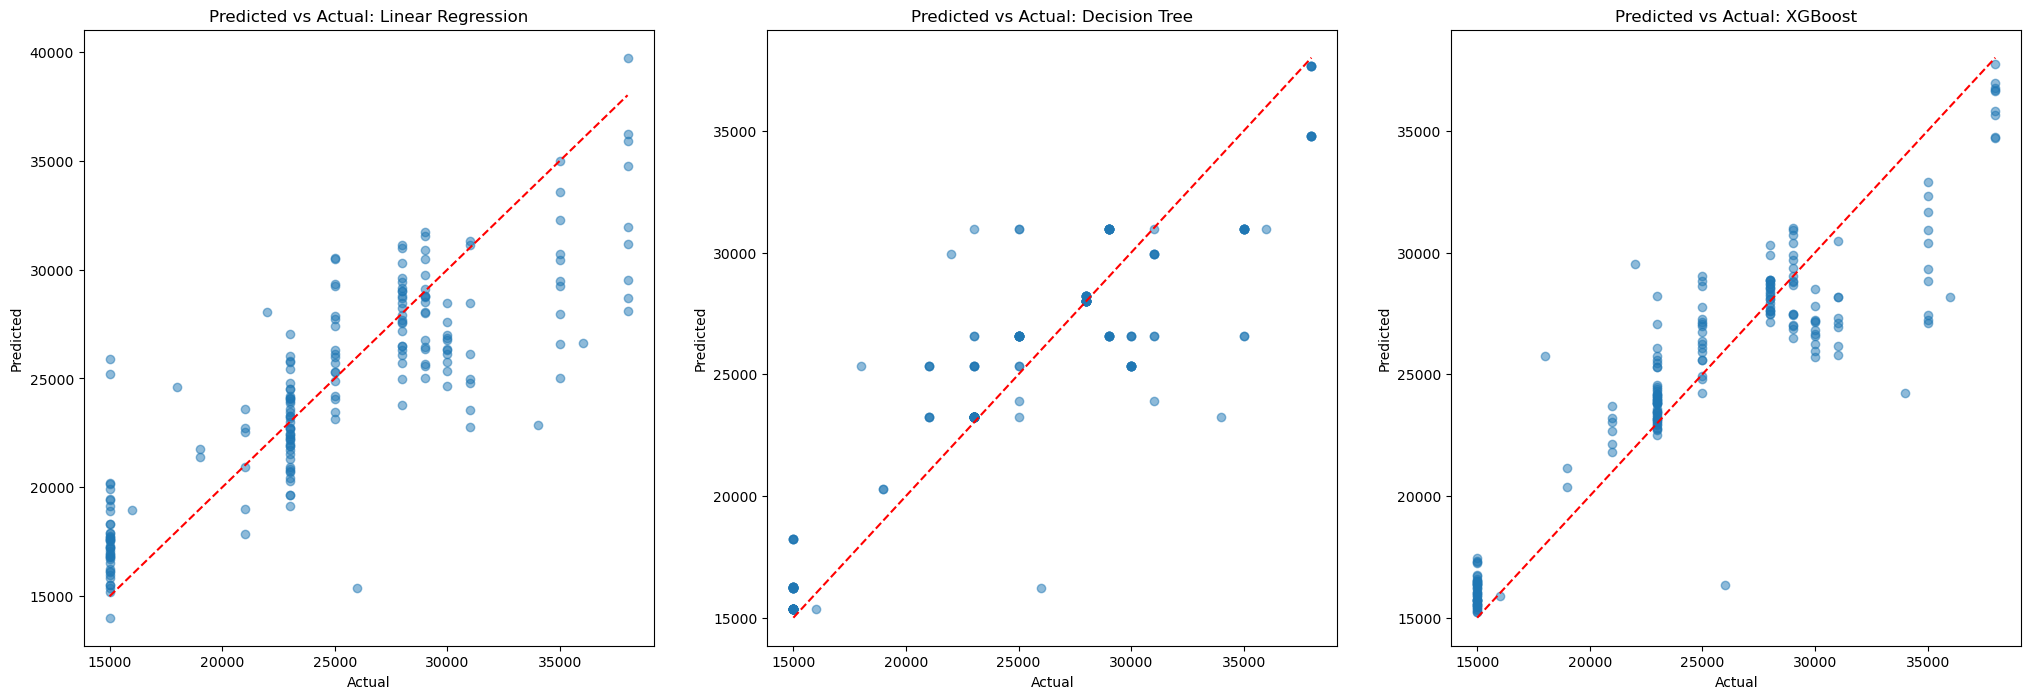

In [23]:
figure, ax = plt.subplots(nrows=1, ncols=3, figsize= (25,8))

ax[0].scatter(y_test, lr.predict(X_test_scaled), alpha=0.5)
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax[0].set_xlabel("Actual")
ax[0].set_ylabel("Predicted")
ax[0].set_title("Predicted vs Actual: Linear Regression")


ax[1].scatter(y_test, dt_best.predict(X_test), alpha=0.5)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax[1].set_xlabel("Actual")
ax[1].set_ylabel("Predicted")
ax[1].set_title("Predicted vs Actual: Decision Tree")


ax[2].scatter(y_test, xgb_best.predict(X_test), alpha=0.5)
ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax[2].set_xlabel("Actual")
ax[2].set_ylabel("Predicted")
ax[2].set_title("Predicted vs Actual: XGBoost")

plt.show()

In [24]:
booster = xgb_best.get_booster()
X_test_names = ['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants','AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily','BMI', '#MajorSurgeries']

In [26]:
import xgboost as xgb

In [27]:
dtest = xgb.DMatrix(
    X_test,
    feature_names=X_test_names
)

In [28]:
shap_values_xgb = booster.predict(
    dtest,
    pred_contribs=True
)
# remove bias term (last column)
shap_values_xgb = shap_values_xgb[:, :-1]

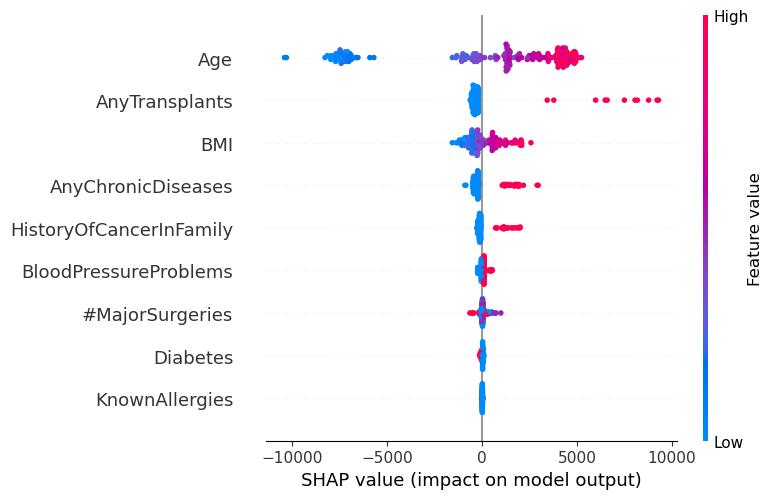

In [29]:
shap.summary_plot(
    shap_values_xgb,
    X_test,
    feature_names=X_test.columns
)

### The plot shows the impact of features on model predictions. Age and AnyTransplants have the highest influence, with Age contributing both positively and negatively to premiums, while AnyTransplants consistently increases predicted premiums. BMI, AnyChronicDiseases, and HistoryOfCancerInFamily have moderate impacts, with both positive and negative contributions. #MajorSurgeries shows an inverse effect—higher surgery counts reduce predicted premiums, and lower counts increase them.

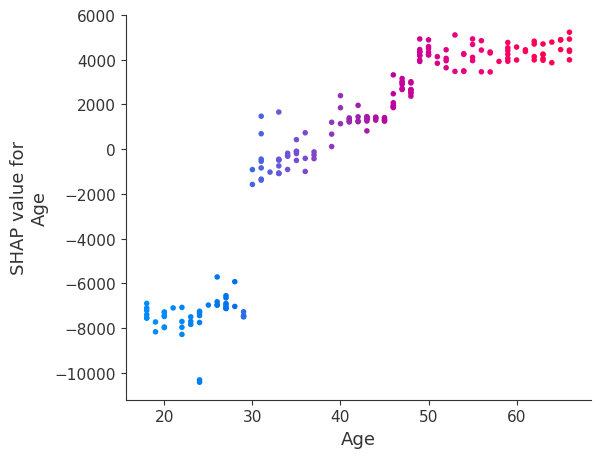

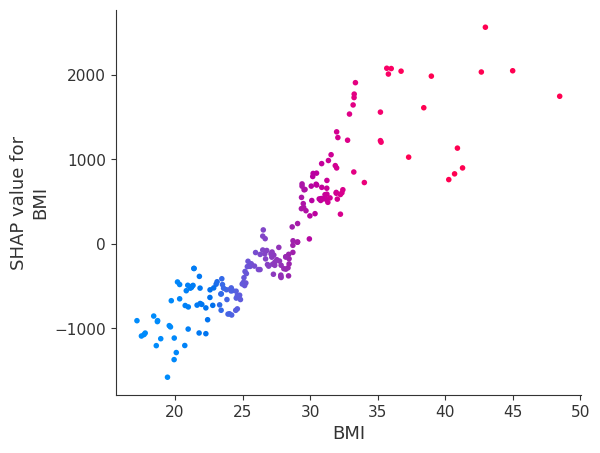

In [30]:
shap.dependence_plot("Age", shap_values_xgb, X_test, interaction_index="Age")
shap.dependence_plot("BMI", shap_values_xgb, X_test, interaction_index="BMI")

### The SHAP values for Age generally increase from around 35 to 50, indicating a rising contribution to predicted premiums. Beyond 60, SHAP values mostly stabilize. Between ages 50–60, SHAP values span a wide range (~3000 to 5000), showing more variability in predictions. For younger ages (around 30), SHAP values are concentrated at extremes (-7000 and -1000) with no intermediate values, reflecting less consistent model impact at lower ages.
### SHAP values for BMI steadily increase for BMI values between 20 and 34, indicating a rising contribution to predicted premiums. Beyond 34, SHAP values are more randomly scattered, suggesting less consistent impact on predictions for higher BMI. For lower BMI values (18–24), SHAP values show slight scatter, reflecting moderate variability in the model’s response at this range.

In [31]:
explainer = shap.TreeExplainer(dt_best)
shap_values_dt = explainer.shap_values(X_test)

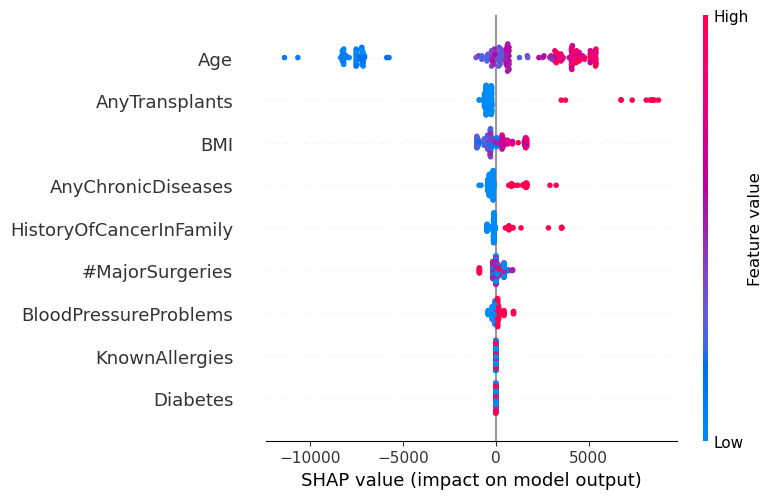

In [32]:
shap.summary_plot(shap_values_dt, X_test)

### The plot shows the impact of features on model predictions. Age and AnyTransplants have the highest influence, with Age contributing both positively and negatively to premiums, while AnyTransplants consistently increases predicted premiums. BMI, AnyChronicDiseases, and HistoryOfCancerInFamily have moderate impacts, with both positive and negative contributions. #MajorSurgeries shows an inverse effect—higher surgery counts reduce predicted premiums, and lower counts increase them.The XGBoost model shows good overlap between actual and predicted values across the low to mid-range premium values (approximately 15,000–30,000), indicating strong predictive performance for the majority of policyholders.

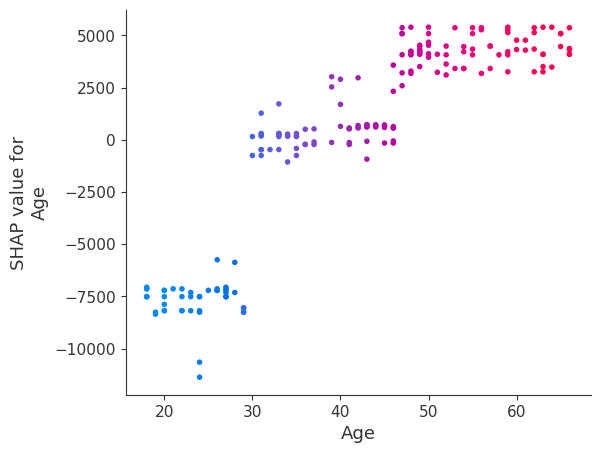

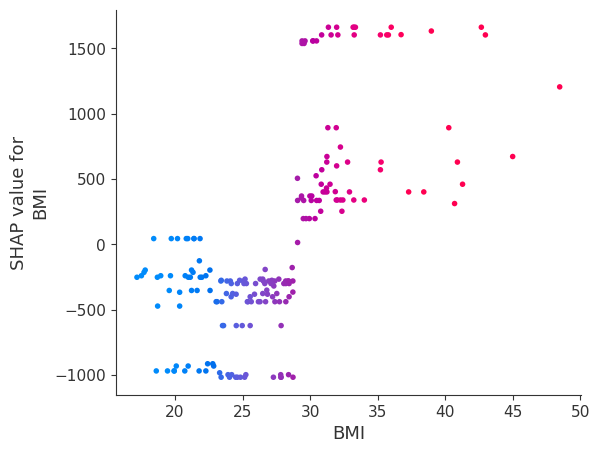

In [33]:
shap.dependence_plot("Age", shap_values_dt, X_test, interaction_index="Age")
shap.dependence_plot("BMI", shap_values_dt, X_test, interaction_index="BMI")

### The SHAP values for Age generally increase from age 30 and remain in the same broad range till age 47 after which the SHAP values further increase and remain in the same broad range for all further ages. The age group compositions affecting SHAP at different points are different for DT alg from those observed for XGBoost alg For younger ages (around 30), SHAP values are concentrated at extremes (-7500 and 0) with no intermediate values, reflecting less consistent model impact at lower ages.
### SHAP values for BMI is spread out between -1000 and 500 for BMI values between 20 and 30, indicating a lack of direct influence on model. Beyond 30, the SHAP values are random suggesting that for obese or extreme BMI cases, the model does not change much. This result is quite different to XGBoost's results where lower to medium BMI values show steady increase in SHAP values.

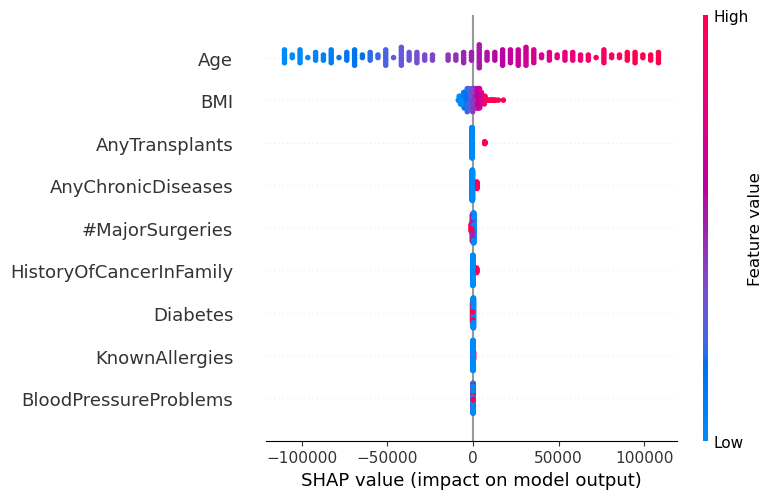

In [34]:
explainer_lr = shap.LinearExplainer(lr,X_train)
shap_values_lr = explainer_lr.shap_values(X_test)  # returns a shap.Explanation object

# SHAP summary plot
shap.summary_plot(shap_values_lr, X_test_scaled)

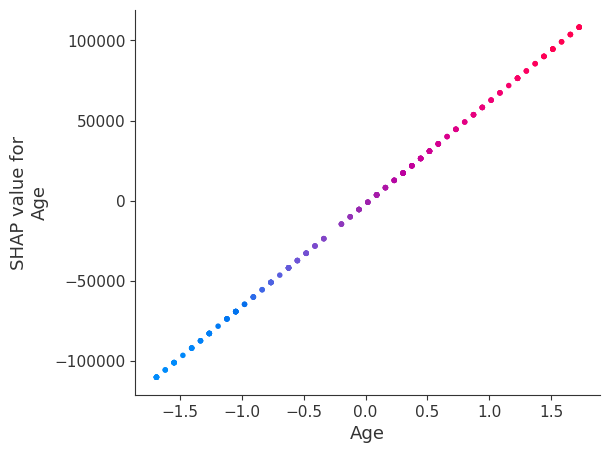

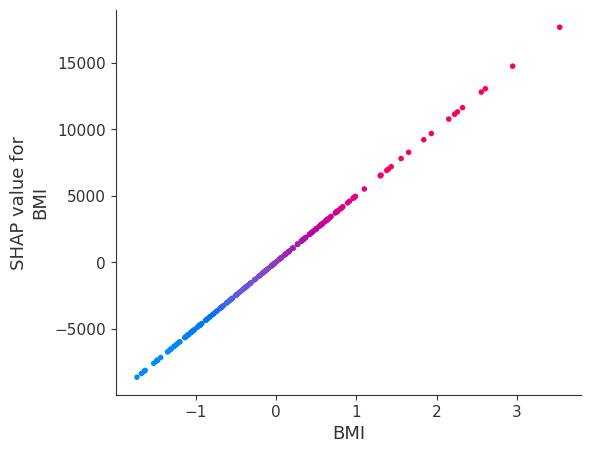

In [35]:
shap.dependence_plot("Age", shap_values_lr, X_test_scaled, interaction_index="Age")
shap.dependence_plot("BMI", shap_values_lr, X_test_scaled, interaction_index="BMI")

In [36]:
X_test.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,BMI,#MajorSurgeries
613,50,0,0,0,0,1,1,30.85,1
451,39,0,0,0,1,1,1,21.33,1
731,65,1,1,0,0,0,0,31.96,0
436,29,0,0,0,0,0,1,21.85,1
275,48,1,1,0,0,1,0,28.73,0


# END of BLOCK3